In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import wandb
from tqdm import tqdm
import utils
from dataset import StateActionEffectDataset
import environment

run_id = "3okblzeq"


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
pybullet build time: May 20 2022 19:44:17


In [26]:
def visualize_dataset(test_set, r):

    x = test_set.effect[:,:,0].abs().max(dim = -1)[0]
    y = test_set.effect[:,:,1].abs().max(dim = -1)[0]
    z = test_set.effect[:,:,2].abs().max(dim = -1)[0]
    rot_x = test_set.effect[:,:,3].abs().max(dim = -1)[0]
    rot_y = test_set.effect[:,:,4].abs().max(dim = -1)[0]
    rot_z = test_set.effect[:,:,5].abs().max(dim = -1)[0]

    
    
    fig, [ax1,ax2] = plt.subplots(2,3)
    fig.set_size_inches(12,9)
    counts, bins = np.histogram(x, bins = 50, range=r)
    counts, bins = np.histogram(y, bins = 50, range=r)
    counts, bins = np.histogram(z, bins = 50, range=r)
    counts, bins = np.histogram(rot_x, bins = 50, range=r)
    counts, bins = np.histogram(rot_y, bins = 50, range=r)
    counts, bins = np.histogram(rot_z, bins = 50, range=r)
    
    ax1[0].stairs(counts, bins)
    ax1[2].stairs(counts, bins)
    ax1[1].stairs(counts, bins)
    ax1[0].set_title("x")
    ax1[1].set_title("y")
    ax1[2].set_title("z")
    
    ax2[0].stairs(counts, bins)
    ax2[1].stairs(counts, bins)
    ax2[2].stairs(counts, bins)
    ax2[0].set_title("rot_x")
    ax2[1].set_title("rot_y")
    ax2[2].set_title("rot_z")

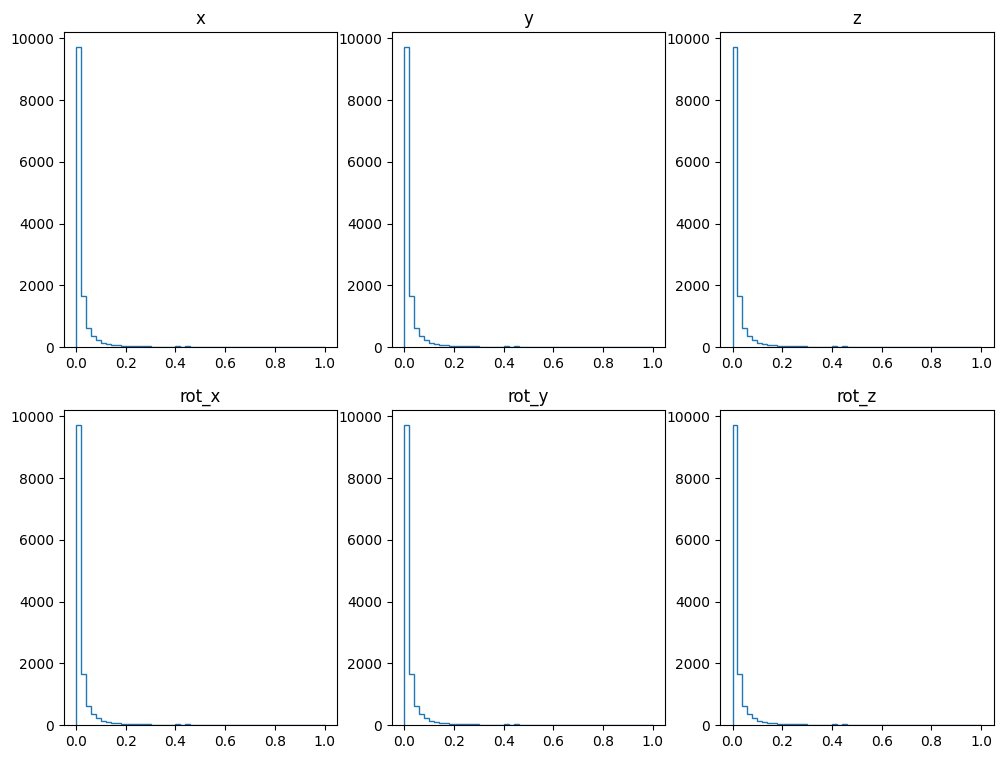

In [28]:
visualize_dataset(test_set, (0,1))

In [3]:
train_set = StateActionEffectDataset("v4", "train")
val_set = StateActionEffectDataset("v4", "val")
test_set = StateActionEffectDataset("v4", "test")

In [27]:
count = 0
for e in train_set.effect:
    if torch.any(e.abs() > 3e-2):
        count += 1

In [18]:
len(train_set)

160000

In [28]:
( count)/ len(train_set) * 100

68.918125

In [5]:
x.size()

NameError: name 'x' is not defined

In [21]:
visualize_dataset(train_set,(-4,4))

NameError: name 'visualize_dataset' is not defined

In [ ]:
x = torch.cat([k for k in test_set.effect])[:, 0]
y = torch.cat([k for k in test_set.effect])[:, 1]
z = torch.cat([k for k in test_set.effect])[:, 2]
rot_x = torch.cat([k for k in test_set.effect])[:, 0+3 ]
rot_y = torch.cat([k for k in test_set.effect])[:, 1+3 ]
rot_z = torch.cat([k for k in test_set.effect])[:, 2+3 ]

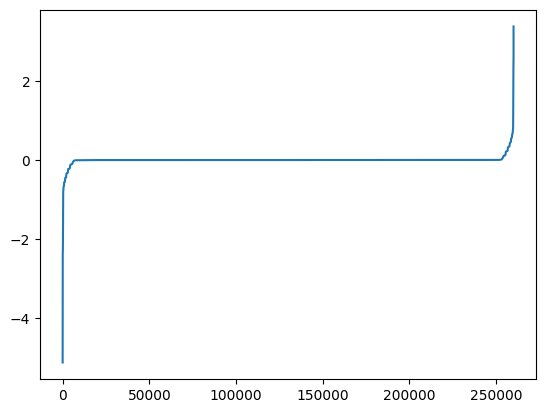

In [57]:
x.sort()
plt.plot(x.numpy())

In [3]:
run = wandb.init(entity="colorslab",project="multideepsym", resume="must", id=run_id)
run = wandb.Api().run("colorslab/multideepsym/" + run_id)
model = utils.create_model_from_config(run.config)
model.load("_best", from_wandb=True)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: mbatuhancelik (colorslab). Use `wandb login --relogin` to force relogin


wandb: ERROR Failed to sample metric: Not Supported


In [4]:
def single_iteration_data(data):
    for key in ["action", "state", "effect"]:
        data[key] = data[key].unsqueeze(0).expand(-1, 13, -1)
    data["pad_mask"] = data["pad_mask"].unsqueeze(0).expand(-1, 13)
    return data

In [5]:

val_loss = {}
predictions = {}
for i in tqdm(range(len(val_set))):
    sample = single_iteration_data(val_set.__getitem__(i))
    with torch.no_grad():
        loss, pred = model.loss_with_pred(sample)
        val_loss[loss.cpu().item()] = i
        predictions[loss.cpu().item()] = pred.cpu()

loss_sorted = list(val_loss.keys())
loss_sorted.sort()

100%|██████████| 20000/20000 [00:57<00:00, 346.36it/s]


In [61]:
def plot_effect(effect):
    num_objects = 13
    x = np.arange((num_objects))  # the label locations
    width = 0.33  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(nrows = 1,constrained_layout=True)
    labels = ["dx","dy" , "dz"]
    for i in range(3):
        offset = width * multiplier
        rects = ax.bar(x + offset,effect[:,i], width, label=labels[i])
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Length (m)')
    ax.set_title('effect')
    ax.set_xticks(x + width, "")
    ax.legend(ncols=3)

def plot_effect_prediction_difference(loss):
    print(loss)
    id = val_loss[loss]
    sample = train_set.__getitem__(id)
    num_objects = torch.count_nonzero(sample["pad_mask"]).item()
    num_objects = 13
    x = np.arange((num_objects))  # the label locations
    width = 0.33  # the width of the bars
    multiplier = 0

    fig, [ax, ax2] = plt.subplots(nrows = 2,constrained_layout=True)
    labels = ["dx","dy" , "dz"]
    for i in range(3):
        offset = width * multiplier
        rects = ax.bar(x + offset,( predictions[loss].cpu() - sample["effect"])[:,:num_objects,i][0].numpy(), width, label=labels[i])
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Length (m)')
    ax.set_title('prediction - effect')
    ax.set_xticks(x + width, "")
    ax.legend(ncols=3)

    labels = ["rot_x","rot_y" , "rot_z"]
    for i in range(3):
        offset = width * multiplier
        rects = ax2.bar(x + offset,( predictions[loss].cpu() - sample["effect"])[:,:num_objects,i+ 3][0].numpy(), width, label=labels[i])
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel('in radians')
    # ax2.set_title('Objects')
    ax2.set_xticks(x + width, "")
    ax2.legend(ncols=3)
    # ax.set_ylim(0, 10)

    plt.show()

def plot_prediction_effect_ds(loss):
    print(loss)
    id = val_loss[loss]
    print(id)
    sample = val_set.__getitem__(id)
    num_objects = 13
    x = np.arange((num_objects))  # the label locations
    width = 0.33  # the width of the bars
    multiplier = 0

    fig, [ax, ax2] = plt.subplots(nrows = 2,constrained_layout=True)
    labels = ["dx","dy" , "dz"]
    for i in range(3):
        offset = width * multiplier
        rects = ax.bar(x + offset,( predictions[loss].cpu())[:,:num_objects,i][0].numpy(), width, label=labels[i])
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Length (m)')
    ax.set_title('prediction')
    ax.set_xticks(x + width, "")
    ax.legend(ncols=3)
    labels = ["dx","dy" , "dz"]
    for i in range(3):
        offset = width * multiplier
        rects = ax2.bar(x + offset, sample["effect"][:,i].numpy(), width, label=labels[i])
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel('Length (m)')
    ax2.set_title('effect')
    ax2.set_xticks(x + width, "")
    ax2.legend(ncols=3)

def visualize_ds(loss):
    fig = plt.figure(figsize=(18, 6))

    xy_actual = fig.add_subplot( 1,3,1 , xlabel="x", ylabel="y",xlim = (0.45, 1.45), ylim = (-0.45, 0.50))
    xz_actual = fig.add_subplot( 1,3,2 , xlabel="x", ylabel="z",xlim = (0.45, 1.45), ylim = (0.3, 0.6))
    yz_actual = fig.add_subplot( 1,3,3 , xlabel="y", ylabel="z",xlim = (-0.45, 0.50), ylim = (0.3, 0.6))
    sample = val_set.__getitem__(val_loss[loss])
    pred = predictions[loss][0]

    state = sample["state"]
    effect = sample["effect"]
    x, y, z =state[:, 0] ,state[:, 1],state[:, 2]
    u,v,w, u2, v2,w2 = effect[:,0],effect[:,1],effect[:,2],pred[:,0],pred[:,1],pred[:,2]

    # x, y, z =[0, 1 , 4] ,[1 , 4 , 5],[ 3.4, 2.1, 1.9]
    # u,v,w, u2, v2,w2 = [1, 0 , 3],[1, 4 , 3],[0,2,4],pred[:,0][:3],pred[:,1][:3],pred[:,2][:3]

    for i in range(13):
        xy_actual.plot([x[i],x[i] + u[i]],[y[i], y[i] + v[i]],color ="b")
        xy_actual.plot([x[i],x[i] +  u2[i]],[y[i], y[i] + v2[i]],color ="r", alpha = 0.5)
        yz_actual.plot([y[i],y[i] +  v[i]],[z[i], z[i] + w[i]],color ="b")
        yz_actual.plot([y[i],y[i] +  v2[i]],[z[i], z[i] + w2[i]],color ="r", alpha = 0.5)
        xz_actual.plot([x[i],x[i] +  u[i]],[z[i], z[i] + w[i]],color ="b")
        xz_actual.plot([x[i],x[i] + u2[i]],[z[i], z[i] + w2[i]],color ="r", alpha = 0.5)

    xy_actual.set_title("Effect")

def compare_vectors(loss):
    fig = plt.figure(figsize=( 17, 39))
    xy , yz , xz = [], [], []

    
    sample = val_set.__getitem__(val_loss[loss])
    pred = predictions[loss][0]

    state = sample["state"]
    effect = sample["effect"]
    x, y, z =state[:, 0].numpy() ,state[:, 1].numpy() ,state[:, 2].numpy() 
    u,v,w, u2, v2,w2 = effect[:,0].numpy() ,effect[:,1].numpy() ,effect[:,2].numpy() ,pred[:,0].numpy() ,pred[:,1].numpy() ,pred[:,2].numpy() 

    for i in range(13):
        xy.append(fig.add_subplot( 13,3,i*3 + 1 , xlabel="x", ylabel="y" ))
        yz.append(fig.add_subplot( 13,3,i*3 + 3 , xlabel="y", ylabel="z" ))
        xz.append(fig.add_subplot( 13,3,i*3 + 2  , xlabel="x", ylabel="z"))


    for i in range(13):
        yz[i].plot([y[i],y[i] + v2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
        xz[i].plot([x[i],x[i] + u2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
        xy[i].plot([x[i],x[i] + u2[i]],[y[i], y[i]+ v2[i]],color ="r", label= "prediction", alpha= 0.7)
        xy[i].plot([x[i],x[i] + u[i]],[y[i], y[i]+ v[i]],  color ="b", label= "effect")
        yz[i].plot([y[i],y[i] + v[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
        xz[i].plot([x[i],x[i] + u[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
        if sample["pad_mask"][i] == 0:
            xy[i].set_ylabel("Non existent object")
        else:
            xy[i].set_ylabel(str(i))

    xy[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                          ncols=2, mode="expand", borderaxespad=0.)

In [ ]:
env =  environment.BlocksWorld_v4(gui=1, min_objects=8, max_objects=13)

In [49]:

def replay(id, set):
    
    env.delete_objects()
    state = set.state[id]
    for o in state:
        env.create_object_from_db(o.numpy())
    a= set.action[id]
    e, _ = env.step((a[0].item(), a[1].item()), 
    (a[2].item(),a[3].item()), a[4].item(), a[5].item())
    return e
    

In [11]:
loss_sorted[0]

125.07475280761719

In [12]:
loss_sorted.reverse()

AttributeError: 'numpy.float32' object has no attribute 'numpy'

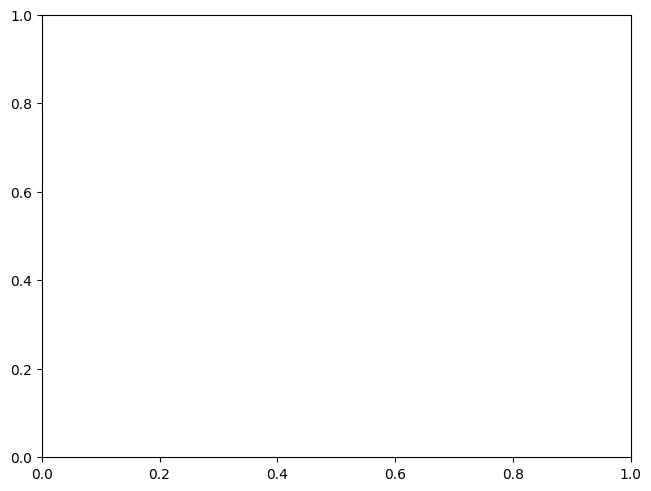

In [44]:
replay(index, val_set)

In [33]:
val_set.action[index]

tensor([6, 7, 6, 6, 0, 0], dtype=torch.int32)

0.40824568271636963
0.40824568271636963
11118


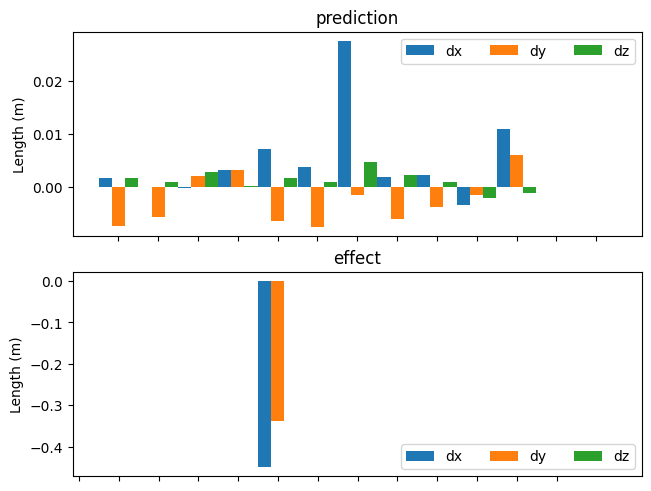

In [32]:
index = 2607
print(loss_sorted[index])
plot_prediction_effect_ds(loss_sorted[index])
# visualize_ds(loss_sorted[index])
# compare_vectors(loss_sorted[index])
replay(index, val_set)

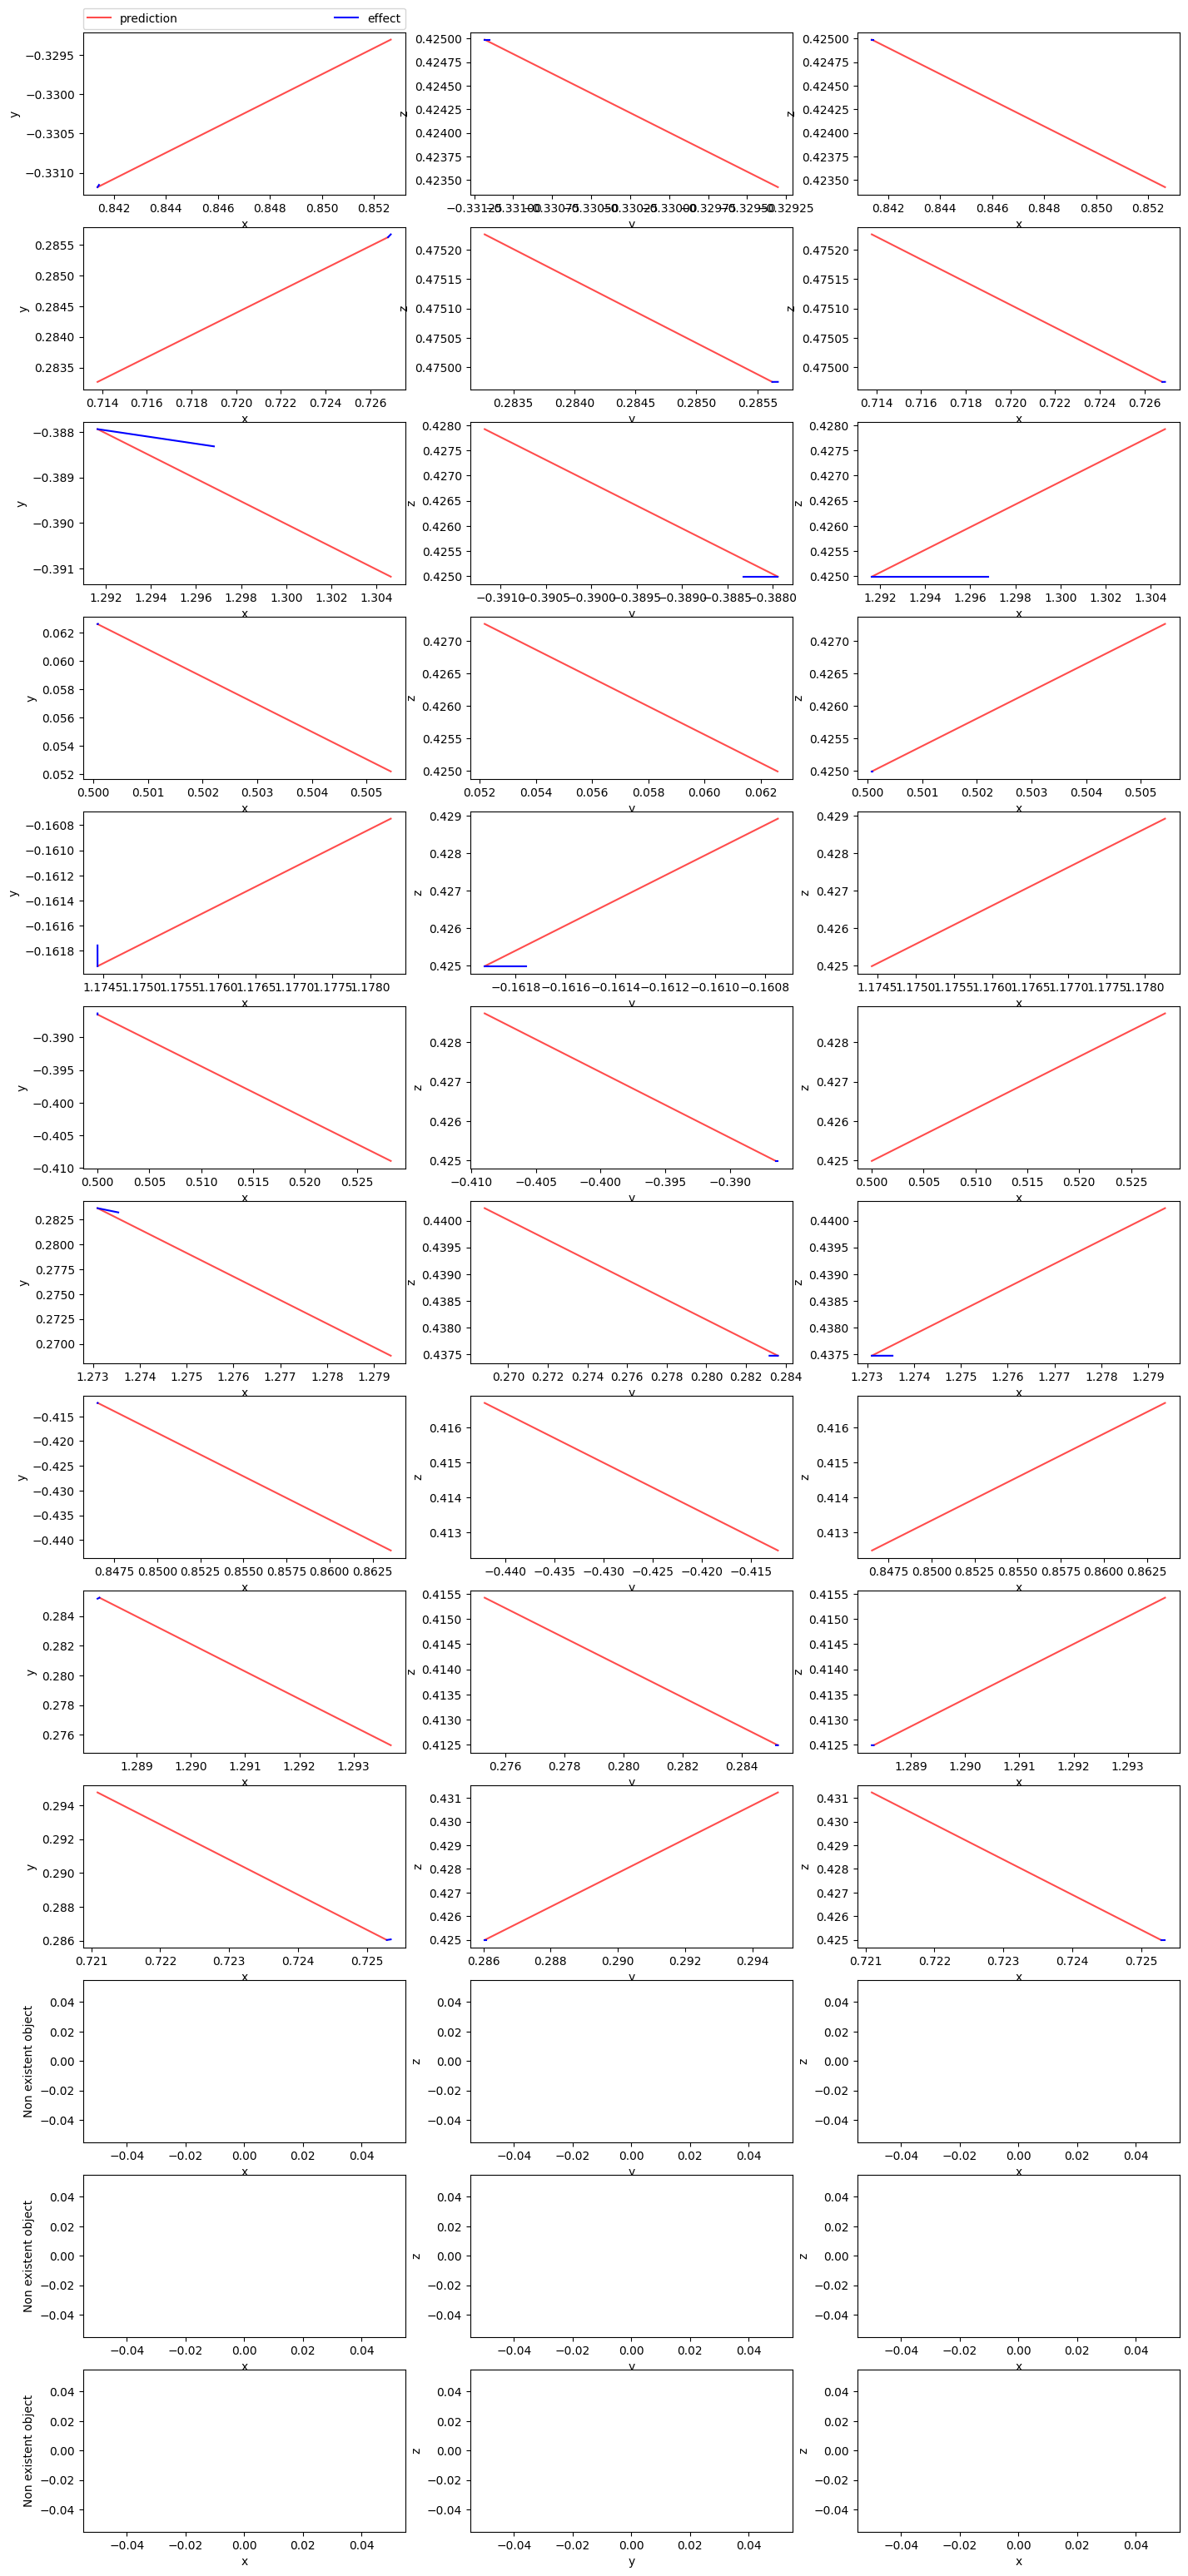

In [14]:

fig = plt.figure(figsize=( 17, 39))
xy , yz , xz = [], [], []

loss = loss_sorted[1000]
sample = val_set.__getitem__(val_loss[loss])
pred = predictions[loss][0]

state = sample["state"]
effect = sample["effect"]
x, y, z =state[:, 0].numpy() ,state[:, 1].numpy() ,state[:, 2].numpy() 
u,v,w, u2, v2,w2 = effect[:,0].numpy() ,effect[:,1].numpy() ,effect[:,2].numpy() ,pred[:,0].numpy() ,pred[:,1].numpy() ,pred[:,2].numpy() 

for i in range(13):
    xy.append(fig.add_subplot( 13,3,i*3 + 1 , xlabel="x", ylabel="y" ))
    yz.append(fig.add_subplot( 13,3,i*3 + 2 , xlabel="y", ylabel="z" ))
    xz.append(fig.add_subplot( 13,3,i*3 + 3  , xlabel="x", ylabel="z"))


for i in range(13):
    yz[i].plot([y[i],y[i] + v2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
    xz[i].plot([x[i],x[i] + u2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
    xy[i].plot([x[i],x[i] + u2[i]],[y[i], y[i]+ v2[i]],color ="r", label= "prediction", alpha= 0.7)
    xy[i].plot([x[i],x[i] + u[i]],[y[i], y[i]+ v[i]],  color ="b", label= "effect")
    yz[i].plot([y[i],y[i] + v[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
    xz[i].plot([x[i],x[i] + u[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
    if sample["pad_mask"][i] == 0:
        xy[i].set_ylabel("Non existent object")

xy[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=2, mode="expand", borderaxespad=0.)


In [24]:
vals

torch.return_types.max(
values=tensor([3.5173e-04, 3.3769e-04, 6.6113e-01,  ..., 1.4526e-02, 1.9824e-02,
        1.1168e-01]),
indices=tensor([2, 3, 2,  ..., 1, 5, 2]))

In [21]:
vals = val_set.effect[:,:,0].abs().max(dim = -1)

In [25]:
np.histogram(vals[0], bins = 50, range=(-1,1))

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 9150,  362, 2196,  204,  153, 1947,  126,  135,
        1527,   92,  317, 1030,  110,  653,  265,   88,  648,   47,   72,
         274,    7,   12,    7,    8,    9]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ], dtype=float32))

In [18]:
val_set.effect[0]

tensor([[ 5.9366e-05,  1.6782e-04,  0.0000e+00, -8.7792e-08,  1.3563e-09,
          2.3732e-03],
        [ 5.9366e-05,  1.6782e-04,  0.0000e+00, -8.7792e-08,  1.3563e-09,
          2.3732e-03],
        [-3.5173e-04,  2.6000e-04,  1.3411e-06, -6.1856e-05,  1.1458e-06,
          2.2535e-03],
        [ 5.9307e-05,  1.6782e-04,  0.0000e+00, -8.7792e-08,  1.3563e-09,
          2.3732e-03],
        [ 3.1352e-05,  4.2498e-05,  0.0000e+00,  1.4234e-10,  9.8225e-10,
         -2.9775e-04],
        [ 3.1233e-05,  4.2506e-05,  0.0000e+00,  1.4234e-10,  9.8225e-10,
         -2.9775e-04],
        [-6.5565e-07,  1.6662e-04,  0.0000e+00,  3.6598e-09, -1.3366e-08,
         -1.6014e-03],
        [-5.9605e-07,  1.6664e-04,  0.0000e+00,  3.6598e-09, -1.3366e-08,
         -1.6014e-03],
        [-6.5565e-07,  1.6662e-04,  0.0000e+00,  3.6598e-09, -1.3366e-08,
         -1.6014e-03],
        [-6.5565e-07,  1.6665e-04,  0.0000e+00,  3.6598e-09, -1.3366e-08,
         -1.6014e-03],
        [-6.5565e-07,  1.6664e